In [16]:
# Imports

import numpy as np
import pathlib
import matplotlib.pyplot as plt
import IPython
import sys
import cv2
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL.Image
from PIL import ImageOps
import PIL
import datetime
import tensorboard
import sklearn
import subprocess
import pandas
import time
import glob
from IPython import display

%load_ext autoreload
%autoreload 2

from google.colab import drive             
drive.mount('/content/drive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Dataset loading

data_path = pathlib.Path('/content/drive/MyDrive/CarsDataset/')

# data_path_test = pathlib.Path('/content/drive/MyDrive/CarsDataset')


dataset_path = tf.keras.utils.image_dataset_from_directory(        # Training dataset
    data_path,
    labels= 'inferred',
    label_mode= None,
    validation_split=0.2,
    subset='training',
    seed= 1,
    batch_size=5,
    image_size=(140, 140),
    color_mode="rgb",
    shuffle=True)

dataset_path_val = tf.keras.utils.image_dataset_from_directory(      #Validation dataset
    data_path,
    labels= 'inferred',
    label_mode= None,
    validation_split=0.2,
    subset='validation',
    seed= 2,
    batch_size=5,
    image_size=(140, 140),
    color_mode="rgb",
    shuffle=True)


# (train_images, train_labels) = dataset_path
BUFFER_SIZE = 60000
BATCH_SIZE = 5
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 1
    

Found 8144 files belonging to 1 classes.
Using 6516 files for training.
Found 8144 files belonging to 1 classes.
Using 1628 files for validation.


In [18]:
# The generator

# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
def make_generator_model():
    model = tf.keras.Sequential([
    # tf.keras.layers.Reshape((5, 28, 28, 1)),
    tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),    
    tf.keras.layers.Dense(35*35*1024, use_bias=False, input_shape=(100,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Reshape((35, 35, 1024)),
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    tf.keras.layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    # assert model.output_shape == (None, 7, 7, 128)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    # assert model.output_shape == (None, 7, 7, 128)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    # assert model.output_shape == (None, 7, 7, 128)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    # assert model.output_shape == (None, 14, 14, 64)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='LeakyReLU'),
    # assert model.output_shape == (None, 28, 28, 1)
    ])
    return model




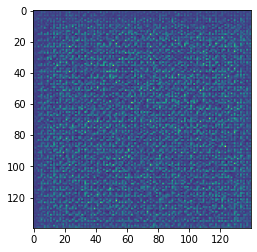

In [19]:
# Image generation

generator = make_generator_model()    
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

In [20]:
# The discriminator

def make_discriminator_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same',input_shape=[140, 140, 3]),
    tf.keras.layers.LeakyReLU(),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])
    return model

    

In [21]:
# Decision making

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-4.560352e-06]], shape=(1, 1), dtype=float32)


In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
# Discriminator loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
# Optimizers

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
#      checkpoint.save(file_prefix = checkpoint_prefix)
      print("fifteenth is here")
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    if (epoch + 1) % 1 == 0:
      print("beedoo")
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.savefig('image_at_epoch_{}.png'.format(epoch))
  plt.show()

In [ ]:
# plt.imshow(generated_image[0])
# plt.show()

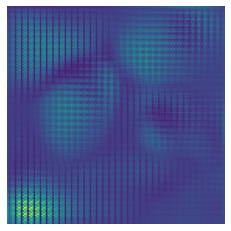

In [ ]:
# Train the model
train(dataset_path, EPOCHS)
